# Harry Potter Classification



In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.1MB/s 
     |████████████████████████████████| 1.2MB 14.2MB/s 
     |████████████████████████████████| 204kB 34.8MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

### Download Images


In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'xxxxxxxxxx')

In [ ]:
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
!pip install azure-cognitiveservices-search-imagesearch

from itertools import chain

from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

def search_images_bing2(key, term, max_images: int = 150, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 40kB 4.8MB/s 
     |████████████████████████████████| 92kB 7.2MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 3.2MB 33.8MB/s 


In [ ]:
results = search_images_bing(key, 'harry potter face')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
dest = '/content/harrypotter.jpg'
download_url(ims[0], dest)

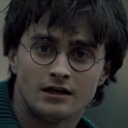

In [ ]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [ ]:
characters = 'Harry Potter',' Hermione Granger','Ron Weasley'
path = Path('characters')

In [ ]:
if not path.exists():
  path.mkdir()
  for o in characters:
    dest = (path/o)
    dest.mkdir(exist_ok = True)
    results = search_images_bing(key, f'{o} characters')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#402) [Path('characters/ Hermione Granger/00000140.jpg'),Path('characters/ Hermione Granger/00000062.jpg'),Path('characters/ Hermione Granger/00000149.gif'),Path('characters/ Hermione Granger/00000039.jpg'),Path('characters/ Hermione Granger/00000005.jpg'),Path('characters/ Hermione Granger/00000010.jpg'),Path('characters/ Hermione Granger/00000101.jpg'),Path('characters/ Hermione Granger/00000148.jpg'),Path('characters/ Hermione Granger/00000027.png'),Path('characters/ Hermione Granger/00000016.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#1) [Path('characters/Ron Weasley/00000088.jpg')]

In [ ]:
failed.map(Path.unlink);

### Classifier

In [ ]:
wizard = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label, 
    item_tfms = Resize(128))

In [ ]:
path = '/content/gdrive/MyDrive/Projects/HP_characters/Main'
dls = wizard.dataloaders(path)

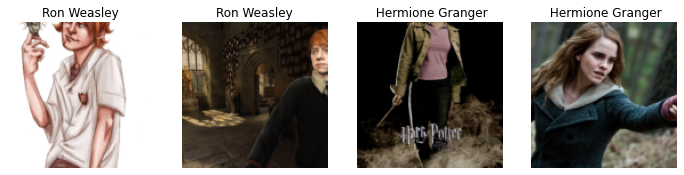

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

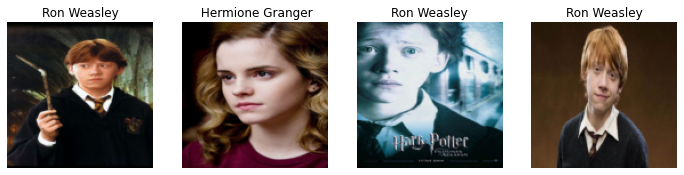

In [ ]:
# squishing the images to fit the size
wizard = wizard.new(item_tfms = Resize(128, ResizeMethod.Squish))
dls = wizard.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows = 1)

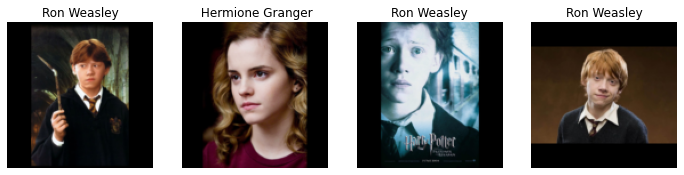

In [ ]:
# resizing the images to keep as is. 
wizard = wizard.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = wizard.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(4)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export('/content/gdrive/MyDrive/Projects/HP_characters/HP3char_061421.pkl')

In [ ]:
Path = '/content/gdrive/MyDrive/Projects/HP_characters/Main'

In [ ]:
learn_inf = load_learner('/content/gdrive/MyDrive/Projects/HP_characters/HP3char_061421.pkl')

In [ ]:
learn_inf.dls.vocab

[' Hermione Granger', 'Harry Potter', 'Ron Weasley']

### Presizing

In [ ]:
wizard = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label, 
    item_tfms = Resize(128),
    batch_tfms = aug_transforms(size = 224, min_scale = 0.75))

In [ ]:
path = '/content/gdrive/MyDrive/Projects/HP_characters/Main'
dls = wizard.dataloaders(path)

### Checking and Debugging a DataBlock

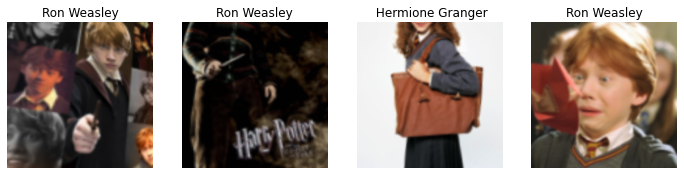

In [ ]:
dls.show_batch(nrows = 1, ncols = 4)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(2)

### Cross-Entropy Loss

In [ ]:
x, y = dls.one_batch()

In [ ]:
y

TensorCategory([10, 13,  4,  6, 15,  1, 15,  4,  4,  4,  8,  8, 18,  3, 15,  7,  8,  0, 16,  7, 10, 12, 18,  8, 10, 17,  9,  6, 12, 16, 15,  2,  4, 11,  6,  2,  1, 11,  2,  2, 11,  4, 13,  0,  0,  0,  1, 18,
         8,  3,  7,  7,  3,  9, 13, 12, 12, 15, 16, 11, 12, 15,  2, 17], device='cuda:0')

In [ ]:
preds,_ = learn.get_preds(dl = [(x, y)])
preds[0]

tensor([1.1622e-06, 2.1497e-06, 2.2574e-05, 3.7882e-08, 5.7579e-07, 3.2095e-07, 5.6514e-08, 3.0019e-07, 2.5094e-07, 8.6460e-06, 9.9648e-01, 3.8257e-07, 1.1691e-08, 3.7870e-08, 7.4471e-09, 3.2785e-03,
        1.0026e-06, 2.0639e-04, 1.0339e-07])

In [ ]:
len(preds[0]), preds[0].sum()

(19, tensor(1.0000))

### The Learning Rate Finder

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(1, base_lr = 0.1)

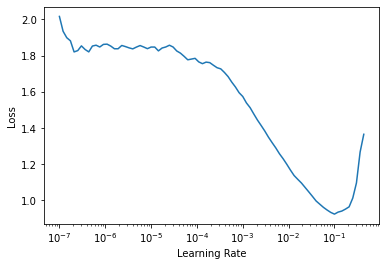

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
lr_min, lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:0.2e}")

Minimum/10: 1.00e-02, steepest point: 1.00e-03


In [ ]:
# applying the steepest point
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(2, base_lr = 1e-3)

### Unfreezing and Transfer Learning

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fit_one_cycle(3, 1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=7.585775892948732e-05)

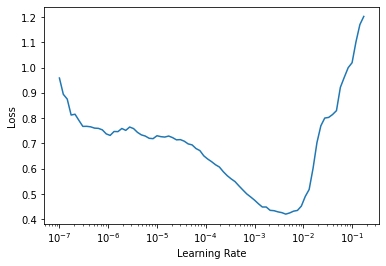

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max = 1e-3)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fit_one_cycle(3, 1e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max = slice(1e-4, 1e-2))

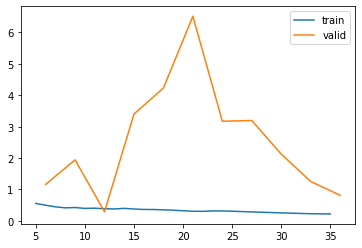

In [ ]:
#graph of training and validation loss
learn.recorder.plot_loss()

In [ ]:
learn.export('/content/gdrive/MyDrive/Projects/HP_characters/HP3char_061421.pkl')

### Production

In [ ]:
wizard = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label, 
    item_tfms = Resize(128),
    batch_tfms = aug_transforms(size = 224, min_scale = 0.75))

In [ ]:
path = '/content/gdrive/MyDrive/Projects/HP_characters/Main'
dls = wizard.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn_inf = load_learner('/content/gdrive/MyDrive/Projects/HP_characters/HP3char_061421.pkl')

In [ ]:
learn_inf.predict('/content/gdrive/MyDrive/Projects/HP_characters/hermonie.jpeg')

(' Hermione Granger', tensor(0), tensor([8.5338e-01, 3.0139e-04, 1.4632e-01]))

In [ ]:
learn_inf.dls.vocab

[' Hermione Granger', 'Harry Potter', 'Ron Weasley']

### Notebook App

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

grab the image:

In [ ]:
btn_upload = SimpleNamespace(data = ['/content/gdrive/MyDrive/Projects/HP_characters/hermonie.jpeg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

Display the image

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

Get predictions

In [ ]:
pred, pred_idx, probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Prbability: {probs[pred_idx]:0.04f}'
lbl_pred

Label(value='Prediction:  Hermione Granger; Prbability: 0.8534')

Button for classification

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

Event handler

In [ ]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128, 128))
  pred, pred_idx, probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:0.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your Wizard!'),
      btn_upload, btn_run, out_pl, lbl_pred])